### Can tools detect exon duplications? 

We will evaluate:

* [exonerate](https://www.ebi.ac.uk/about/vertebrate-genomics/software/exonerate-manual)
* [gmap](http://research-pub.gene.com/gmap/src/README)
* [spaln2](https://github.com/ogotoh/spaln)



In [1]:
%load_ext autoreload
%autoreload 2
from fun import *

In [2]:
fasta_GRCh38_seq_with_dup = SeqIO.parse(open('GRCh38_with_exon_dup.fa'),'fasta')
fasta_GRCh38_seq_with_dup = { fasta.id : str(fasta.seq) for fasta in fasta_GRCh38_seq_with_dup}

In [3]:
with open('../files/GRCh38_duplicated_genes_coords.pkl', 'rb') as handle:
    dups_GRCh38_gene_coords = pickle.load(handle)


### exonerate

* choose model
- protein to genome model

protein2genome
This model allows alignment of a protein sequence to genomic DNA. This is similar to the protein2dna model, with the addition of modelling of introns and intron phases. This model is simliar to those used by genewise.

”cigar" output

In [4]:
# !exonerate genes_with_dup_original_prot_seq.fa GRCh38_with_exon_dup.fa --model protein2genome --showtargetgff True > Exonerate/exonerate_showgff_protein2genome.out.txt 

In [5]:
#parse exonerate output
ex_out_fname = 'Exonerate/exonerate_showgff_protein2genome.out.txt'
ex_format = 'exonerate-text'

In [6]:
hits_feature_intervals = parse_exonerate_output(ex_format, ex_out_fname)
mutated_genes = {value['gene_coord'][0]:key.split('gene:')[1] for key, value in dups_GRCh38_gene_coords.items()}

In [7]:
overlaping_queries_genes = {}
for prot_id, hits in hits_feature_intervals.items():
    for g, hit in enumerate(hits):
        fragments = list(hit['exons']['hit'].values())
#         print((fragments[0][0], fragments[-1][0]))
        for i in list(mutated_genes.keys()):
            if get_overlap((fragments[0][0], fragments[-1][0]), i) > 1:
                overlaping_queries_genes[prot_id] = (mutated_genes[i], g)
#                 print(g, prot_id, mutated_genes[i],i ,(fragments[0][0], fragments[-1][0]))

In [8]:
all_qresult = list(SearchIO.parse(ex_out_fname, ex_format))
hits_feature_intervals = {}
for query in all_qresult:
    id_ = query.id.rsplit('.')[0]
    if id_ not in hits_feature_intervals:
        hits_feature_intervals[id_] = []
    for hit in query:
        hit_dict = {}
        for hsp in hit:
            hit_dict['exons'] = {'query': {'exon_' + str(i): HSPFragment.query_range  
                                            for i, HSPFragment in enumerate(hsp.fragments,1)},
                                 'hit': {'exon_' + str(i): HSPFragment.hit_range
                                          for i, HSPFragment in enumerate(hsp.fragments,1)}}
            hit_dict['introns'] = {'intron_' + str(i): j 
                                   for i, j in enumerate(hsp.hit_inter_ranges,1)}
            hit_dict['align_features'] = {feature: coord for feature, 
                                                              coord in sorted({**hit_dict['introns'],
                                                                               **hit_dict['exons']['hit']}.items(),
                                                                              key=lambda item: item[1][0])}
    hits_feature_intervals[id_].append(hit_dict)


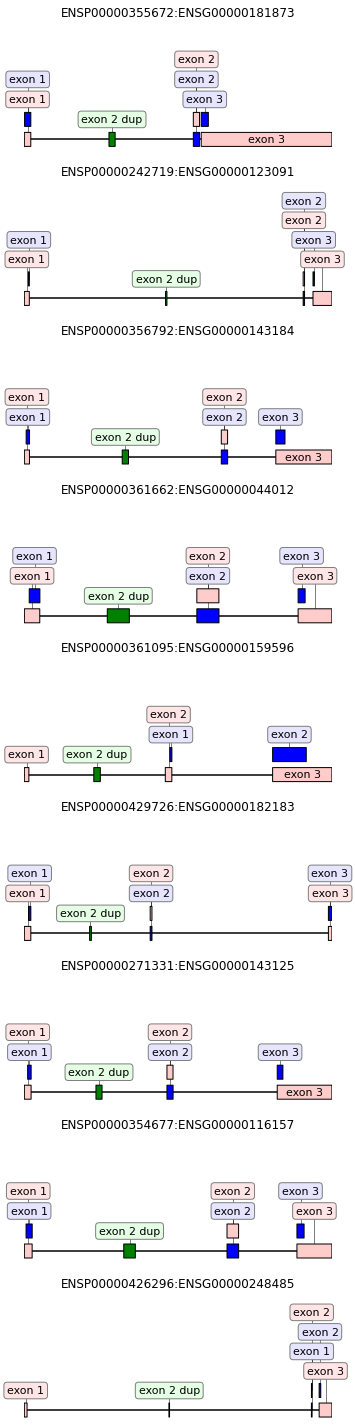

In [9]:
fig, ax = plt.subplots(len(overlaping_queries_genes), figsize=(5,20))
plt.tight_layout()
exon_dup = 2
for hit_idx, (prot_id, gene_id) in enumerate(overlaping_queries_genes.items()):
    gene_id, hit_n = gene_id
    gs, ge = dups_GRCh38_gene_coords['gene:'+gene_id]['gene_coord'][0]
    features = []
    for idx, exon_coord in enumerate(dups_GRCh38_gene_coords['gene:'+gene_id]['exon_coord'],1):
        s, e = exon_coord
        color="#ffcccc"
        labl = 'exon ' + str(idx)
        if idx == exon_dup:
            color = 'green'
            labl = 'exon ' + str(idx) + ' dup'
        if idx > 2:
            idx = idx - 1
            labl = 'exon ' + str(idx)
        features.append(GraphicFeature(start=s, end=e, color=color,
                                       label=labl))
    for idx, query_feat_coord in enumerate([value for key, value in hits_feature_intervals[prot_id][hit_n]['align_features'].items() if 'exon' in key],1):
        qs, qe = query_feat_coord
        labl = 'exon ' + str(idx)
        features.append(GraphicFeature(start=qs, end=qe, color="blue",label=labl))
    record = GraphicRecord(first_index = gs, sequence_length = ge-gs, features=features)
    ax[hit_idx].set_title(prot_id + ':' + gene_id, loc='center')
    #ax[hit_idx].text(0,0,prot_id, ha="right", va="center")
    record.plot(ax=ax[hit_idx],figure_width=5,with_ruler=False)
    
    

##### Will exonerate find the two possible alignments in the same region where the duplication is, or does it require the alignments to hit different parts of the genome sequence?


In [3]:
# !exonerate genes_with_dup_original_prot_seq.fa GRCh38_with_exon_dup.fa --model protein2genome --bestn 2 --showtargetgff True > exonerate_bestn_2_showgff_protein2genome.out.txt

In [8]:
fname = 'Exonerate/exonerate_protein2genome.out.txt'
all_qresult = list(SearchIO.parse(fname, 'exonerate-text'))

In [30]:
!exonerate genes_with_dup_original_prot_seq.fa GRCh38_with_exon_dup.fa --model protein2genome --showtargetgff True > exonerate_protein2genome.out.txt 

Command line: [exonerate genes_with_dup_original_prot_seq.fa GRCh38_with_exon_dup.fa --model protein2genome --showtargetgff True]
Hostname: [rackham2.uppmax.uu.se]

C4 Alignment:
------------
         Query: ENSP00000355672.3 gene:ENSG00000181873.13
        Target: GRCh38_with_exon_dup first chromosome in which 22 genes on the positive strand have duplications of the 2nd exoninserted in the 1st intron
         Model: protein2genome:local
     Raw score: 1865
   Query range: 0 -> 356
  Target range: 228171918 -> 228181949

         1 : MetAlaThrAlaAlaLeuLeuArgGlyAlaThrProGlyArgGlyGlyProV :        18
             ||||||||||||||||||||||||||||||||||||||||||||||||||||
             MetAlaThrAlaAlaLeuLeuArgGlyAlaThrProGlyArgGlyGlyProV
 228171919 : ATGGCGACCGCGGCGCTGCTTCGAGGCGCCACTCCGGGGCGCGGCGGCCCGG : 228171970

        19 : alTrpArgTrpArgLeuArgAlaAlaProArgCysArgLeuAlaHisSerSe :        35
             ||||||||||||||||||||||||||||||||||||||||||||||||||||
             alTrpArgTrpArgLeuArgAlaAla


C4 Alignment:
------------
         Query: ENSP00000242719.3 gene:ENSG00000123091.5
        Target: GRCh38_with_exon_dup first chromosome in which 22 genes on the positive strand have duplications of the 2nd exoninserted in the 1st intron
         Model: protein2genome:local
     Raw score: 811
   Query range: 0 -> 154
  Target range: 51239370 -> 51274102

        1 : MetGlyAsnCysLeuLysSerProThrSerAspAspIleSerLeuLeuHisGlu :       18
            ||||||||||||||||||||||||||||||||||||||||||||||||||||||
            MetGlyAsnCysLeuLysSerProThrSerAspAspIleSerLeuLeuHisGlu
 51239371 : ATGGGGAACTGCCTCAAATCCCCCACCTCGGATGACATCTCCCTGCTTCACGAG : 51239422

       19 : SerGlnSerAspArgAlaSerPheGlyGluGlyThrGluProAspGlnGluPro :       36
            ||||||||||||||||||||||||||||||||||||||||||||||||||||||
            SerGlnSerAspArgAlaSerPheGlyGluGlyThrGluProAspGlnGluPro
 51239423 : TCTCAGTCCGACCGGGCTAGCTTTGGCGAGGGGACGGAGCCGGATCAGGAGCCG : 51239476

       37 : ProProProTyrGln  >>>> Target Intron 1 >>>>  Gl


C4 Alignment:
------------
         Query: ENSP00000493366.1 gene:ENSG00000198104.4
        Target: GRCh38_with_exon_dup first chromosome in which 22 genes on the positive strand have duplications of the 2nd exoninserted in the 1st intron
         Model: protein2genome:local
     Raw score: 1633
   Query range: 0 -> 308
  Target range: 248394258 -> 248395182

         1 : MetAsnGluAsnAsnGluThrLeuThrArgGlyPheThrLeuMetGlyLeuP :        18
             ||||||||||||||||||||||||||||||||||||||||||||||||||||
             MetAsnGluAsnAsnGluThrLeuThrArgGlyPheThrLeuMetGlyLeuP
 248394259 : ATGAATGAAAACAATGAAACCTTGACCAGAGGCTTTACCCTCATGGGGCTCT : 248394310

        19 : heThrHisAsnLysCysSerGlyPhePhePheGlyValIleCysAlaValPh :        35
             ||||||||||||||||||||||||||||||||||||||||||||||||||||
             heThrHisAsnLysCysSerGlyPhePhePheGlyValIleCysAlaValPh
 248394311 : TCACTCACAATAAATGCTCAGGATTCTTTTTCGGTGTCATTTGTGCCGTCTT : 248394361

        36 : ePheMetAlaMetIleAlaAsnGlyValMetIlePheLeuIleAsn

         1 : MetAsnGluAsnAsnGluThrLeuThrArgGlyPheThrLeuMetGlyLeuP :        18
             |||     !.!.|||:!!|||!!!!.!  !! !|||! !|||:!:|||:!!|
             MetAlaTrpGluAsnGlnThrPheAsnSerAspPheIleLeuLeuGlyIleP
 248186482 : ATGGCATGGGAGAATCAGACCTTCAACTCCGACTTCATCCTCCTTGGAATCT : 248186533

        19 : heThrHisAsnLysCysSerGlyPhePhePheGlyValIleCysAlaValPh :        35
             ||!.!|||!:!  !     !  !|||.!!|||  !:!!:!!   !.!:!!||
             heAsnHisSerProProHisThrPheLeuPhePheLeuValLeuGlyIlePh
 248186534 : TCAATCACAGCCCACCACACACGTTCCTCTTCTTTCTGGTCCTGGGCATCTT : 248186584

        36 : ePheMetAlaMetIleAlaAsnGlyValMetIlePheLeuIleAsnIleAsp :        52
             |!!.:!!|||.!.!!:!.!|||..!||||||:!!.!!|||||| !!:!:|||
             eLeuValAlaPheMetGlyAsnSerValMetValLeuLeuIleTyrLeuAsp
 248186585 : TTTAGTGGCCTTCATGGGAAACTCTGTCATGGTTCTCCTCATCTACCTGGAC : 248186635

        53 : ProHisLeuHisThrProMetTyrPheLeuLeuSerHisLeuSerValIleA :        70
              !!!!.||||||||||||||||||||||||||||||!!.|||


C4 Alignment:
------------
         Query: ENSP00000365266.3 gene:ENSG00000204479.4
        Target: GRCh38_with_exon_dup first chromosome in which 22 genes on the positive strand have duplications of the 2nd exoninserted in the 1st intron:[revcomp]
         Model: protein2genome:local
     Raw score: 2166
   Query range: 0 -> 474
  Target range: 12896475 -> 12893546

        1 : MetSerLeuGlnSerProSerArgLeuLeuGluLeuAlaGlyGlnSerLeuLeu :       18
            ||||||||||||:!!|||||||||||||||||||||||||||||||||||||||
            MetSerLeuGlnAlaProSerArgLeuLeuGluLeuAlaGlyGlnSerLeuLeu
 12896475 : ATGAGCCTCCAGGCCCCATCCAGACTGCTGGAGCTGGCAGGGCAGAGCCTGCTG : 12896424

       19 : ArgAsnGlnPheLeuThrIlePheIleLeuAspGluLeuProArgGluValPhe :       36
            ||||||||||||||||||||||||! !|||||||||||||||||||||||||||
            ArgAsnGlnPheLeuThrIlePheThrLeuAspGluLeuProArgGluValPhe
 12896423 : AGGAACCAGTTCTTGACCATCTTCACCCTGGATGAGCTGCCCAGGGAGGTCTTC : 12896370

       37 : ProLeuMetPheMetGluAlaSerSerMetArgHi

        1 : MetSerLeuGlnSerProSerArgLeuLeuGluLeuAlaGlyGlnSerLeuLeu :       18
            ||||||||||||!!!|||||||||||||||||||||||||||||||||||||||
            MetSerLeuGlnThrProSerArgLeuLeuGluLeuAlaGlyGlnSerLeuLeu
 12841985 : ATGAGCCTCCAGACCCCATCCAGACTCCTGGAGCTGGCAGGGCAGAGCCTGCTG : 12841934

       19 : ArgAsnGlnPheLeuThrIlePheIleLeuAspGluLeuProArgGluValPhe :       36
            ||||||||||||||||||||||||! !||||||||||||||||||||||||! !
            ArgAsnGlnPheLeuThrIlePheThrLeuAspGluLeuProArgGluValSer
 12841933 : AGGAACCAGTTCTTGACTATCTTCACCCTGGATGAGCTGCCCAGGGAGGTCTCC : 12841880

       37 : ProLeu :       38
            ||||||
            ProLeu
 12841879 : CCTCTG : 12841872

vulgar: ENSP00000365266.3 0 38 . GRCh38_with_exon_dup 12841985 12841871 - 168 M 38 114
# --- START OF GFF DUMP ---
#
#
##gff-version 2
##source-version exonerate:protein2genome:local 2.4.0
##date 2022-08-26
##type DNA
#
#
# seqname source feature start end score strand frame attributes
#
GRCh38_with_exon_dup	exonerate


C4 Alignment:
------------
         Query: ENSP00000473584.1 gene:ENSG00000204478.11
        Target: GRCh38_with_exon_dup first chromosome in which 22 genes on the positive strand have duplications of the 2nd exoninserted in the 1st intron:[revcomp]
         Model: protein2genome:local
     Raw score: 2014
   Query range: 0 -> 475
  Target range: 13153717 -> 13149867

        1 : MetSerIleArgThrProProArgLeuLeuGluLeuAlaGlyArgSerLeuLeu :       18
            ||||||||||||||||||||||||||||||||||||||||||||||||:!!|||
            MetSerIleArgThrProProArgLeuLeuGluLeuAlaGlyArgSerValLeu
 13153717 : ATGAGCATCCGGACTCCACCCAGACTCCTGGAGCTGGCGGGGCGGAGCGTGCTG : 13153666

       19 : ArgAspGluAlaLeuAlaIleSerThrLeuGluGluLeuProThrGluLeuPhe :       36
            ||||||:!!|||||||||!!:|||||||||||||||||||||||||||||||||
            ArgAspGlnAlaLeuAlaMetSerThrLeuGluGluLeuProThrGluLeuPhe
 13153665 : AGGGACCAAGCCTTGGCCATGTCCACCCTGGAGGAGCTGCCCACAGAACTTTTC : 13153612

       37 : ProProLeuPheMetGluAlaPheSerArgArgH


C4 Alignment:
------------
         Query: ENSP00000357727.3 gene:ENSG00000163220.11
        Target: GRCh38_with_exon_dup first chromosome in which 22 genes on the positive strand have duplications of the 2nd exoninserted in the 1st intron:[revcomp]
         Model: protein2genome:local
     Raw score: 143
   Query range: 3 -> 50
  Target range: 153378577 -> 153378436

         4 : LysMetSerGlnLeuGluArgAsnIleGluThrIleIleAsnThrPheHisG :        21
             ||||||!!!:!!||||||..!:!!:!:|||  !|||:!!|||! !|||||||
             LysMetThrLysLeuGluGluHisLeuGluGlyIleValAsnIlePheHisG
 153378577 : AAGATGACAAAACTTGAAGAGCATCTGGAGGGAATTGTCAATATCTTCCACC : 153378526

        22 : lnTyrSerValLysLeuGlyHisProAspThrLeuAsnGlnGlyGluPheLy :        38
             |||||||||||::!  !||||||  !|||||||||::!:!!||||||.!.||
             lnTyrSerValArgLysGlyHisPheAspThrLeuSerLysGlyGluLeuLy
 153378525 : AATACTCAGTTCGGAAGGGGCATTTTGACACCCTCTCTAAGGGTGAGCTGAA : 153378475

        39 : sGluLeuValArgLysAspLeuGlnAsnPheLeuLys

             ||:!:|||||||||!!.||||||...|||:!!..!|||||| !!  !!..||
             yrValAlaIleCysAsnProLeuArgTyrSerValIleMetGlyLysArgAl
 159318271 : ATGTGGCCATCTGCAACCCCCTAAGGTATTCAGTCATCATGGGTAAGAGGGC : 159318221

       155 : aCysValGlyIleMetAlaValThrTrpGlyIleGlyPheLeuHisSerVal :       171
             ||||:!!  !:!:   :!!! !:!!  !|||||||||.!!  !   :!!:!!
             aCysIleGlnLeuAlaSerGlySerLeuGlyIleGlyLeuGlyMetAlaIle
 159318220 : CTGTATCCAACTGGCCTCTGGATCACTGGGGATTGGCCTTGGCATGGCCATT : 159318170

       172 : SerGlnLeuAlaPheAlaValHisLeuLeuPheCysGlyProAsnGluValA :       189
               !|||:!!.!!! !!.! !!  !|||! !||||||! ! !!  !!  :!!.
             ValGlnValThrSerValPheGlyLeuProPheCysAspAlaPheValIleS
 159318169 : GTCCAAGTAACATCTGTGTTTGGCCTGCCATTCTGTGATGCCTTTGTCATCT : 159318116

       190 : spSerPheTyrCysAspLeuProArgValIleLysLeuAlaCysThrAspTh :       206
             .!  !|||!:!||||||:!!  !!.!:!!:!:||||||||||||||||||||
             erHisPhePheCysAspValArgHisLeuLeuLysLeuAlaCysThrAspTh
 


C4 Alignment:
------------
         Query: ENSP00000350358.4 gene:ENSG00000116726.5
        Target: GRCh38_with_exon_dup first chromosome in which 22 genes on the positive strand have duplications of the 2nd exoninserted in the 1st intron:[revcomp]
         Model: protein2genome:local
     Raw score: 2077
   Query range: 0 -> 483
  Target range: 13284719 -> 13281972

        1 : MetSerLeuGlnAlaProProArgLeuLeuGluLeuAlaGluGlnSerLeuLeu :       18
            ||||||:!!::!|||||||||||||||||||||||||||..!|||!!!||||||
            MetSerIleArgAlaProProArgLeuLeuGluLeuAlaArgGlnArgLeuLeu
 13284719 : ATGAGCATCAGGGCCCCACCCAGACTCCTGGAGCTGGCAAGGCAGAGGCTGCTG : 13284668

       19 : ArgAspArgAlaLeuAlaIleProThrLeuGluGluLeuProArgGluLeuPhe :       36
            ||||||!:!|||||||||||| !!|||:!!||||||||||||||||||||||||
            ArgAspGlnAlaLeuAlaIleSerThrMetGluGluLeuProArgGluLeuPhe
 13284667 : AGGGACCAGGCCTTGGCCATCTCCACCATGGAGGAGCTGCCCAGGGAGCTCTTC : 13284614

       37 : ProProLeuPheMetGluAlaPheThrArgArgCy


C4 Alignment:
------------
         Query: ENSP00000356792.3 gene:ENSG00000143184.5
        Target: GRCh38_with_exon_dup first chromosome in which 22 genes on the positive strand have duplications of the 2nd exoninserted in the 1st intron:[revcomp]
         Model: protein2genome:local
     Raw score: 541
   Query range: 0 -> 114
  Target range: 168548963 -> 168545953

         1 : MetArgLeuLeuIleLeuAlaLeuLeuGlyIleCysSerLeuThrAlaTyrI :        18
             ||||||||||||||||||||||||||||||||||||||||||||||||||||
             MetArgLeuLeuIleLeuAlaLeuLeuGlyIleCysSerLeuThrAlaTyrI
 168548963 : ATGAGACTTCTCATCCTGGCCCTCCTTGGCATCTGCTCTCTCACTGCATACA : 168548912

        19 : leValGlu{G}  >>>> Target Intron 1 >>>>  {ly}ValGlySe :        24
             ||||||||{|}           1796 bp           {||}||||||||
             leValGlu{G}++                         ++{ly}ValGlySe
 168548911 : TTGTGGAA{G}gt.........................ag{GT}GTAGGGAG : 168547098

        25 : rGluValSerAspLysArgThrCysValSerLeuThr


C4 Alignment:
------------
         Query: ENSP00000355652.3 gene:ENSG00000116574.6
        Target: GRCh38_with_exon_dup first chromosome in which 22 genes on the positive strand have duplications of the 2nd exoninserted in the 1st intron:[revcomp]
         Model: protein2genome:local
     Raw score: 424
   Query range: 50 -> 224
  Target range: 112707437 -> 112705237

        51 : LysCysValLeuValGlyAspGlyAlaValGlyLysThrSerLeuValValS :        68
             |||   |||:!!|||||||||||||||  !|||||||||!!!|||:!!:!! 
             LysLeuValIleValGlyAspGlyAlaCysGlyLysThrCysLeuLeuIleV
 112707437 : AAGCTGGTGATCGTTGGGGATGGTGCCTGTGGGAAGACCTGCCTCCTCATCG : 112707386

        69 : erTyrThrThrAsnGlyTyrProThrGluTyrIleProThrAlaPheAspAs :        85
              !!:!!:!! !:!!  !!:!|||  !!  |||:!!||||||!.!|||!!:||
             alPheSerLysAspGlnPheProGluValTyrValProThrValPheGluAs
 112707385 : TCTTCAGCAAGGATCAGTTTCCGGAGGTCTACGTCCCTACTGTCTTTGAGAA : 112707335

        86 : nPheSerAlaValValSerValAspGlyArgPro  


C4 Alignment:
------------
         Query: ENSP00000357067.3 gene:ENSG00000162728.5
        Target: GRCh38_with_exon_dup first chromosome in which 22 genes on the positive strand have duplications of the 2nd exoninserted in the 1st intron:[revcomp]
         Model: protein2genome:local
     Raw score: 667
   Query range: 20 -> 332
  Target range: 160046436 -> 160045494

        21 : ArgGlnArgTyrValGluLysAspGlyArgCysAsnValGlnGlnGlyAsnV :        38
             |||!:!|||  !:!!  !|||||||||||| !!||||||::!..!! !:!!:
             ArgArgArgValLeuThrLysAspGlyArgSerAsnValArgMetGluHisI
 160046436 : CGGCGGAGAGTCCTGACAAAAGATGGTCGCAGCAACGTGAGAATGGAGCACA : 160046385

        39 : alArgGlu<->ThrTyrArgTyrLeuThrAspLeuPheThrThrLeuValAs :        54
             !!  !!!:     !!:!! !||||||! !||||||!::||||||!!!:!!||
             leAlaAspLysArgPheLeuTyrLeuLysAspLeuTrpThrThrPheIleAs
 160046384 : TTGCCGACAAGCGCTTCCTCTACCTCAAGGACCTGTGGACAACCTTCATTGA : 160046334

        55 : pLeuGlnTrpArgLeuSerLeuLeuPhePheValLe


C4 Alignment:
------------
         Query: ENSP00000289753.1 gene:ENSG00000158748.4
        Target: GRCh38_with_exon_dup first chromosome in which 22 genes on the positive strand have duplications of the 2nd exoninserted in the 1st intron:[revcomp]
         Model: protein2genome:local
     Raw score: 309
   Query range: 28 -> 336
  Target range: 23196041 -> 23195045

       29 : ValAlaAlaAlaLeuCysValValIleAlaLeuThrAlaAlaAlaAsnSerLeu :       46
            :!!|||!.!!.!|||! !|||:!!! !  !  !|||!.!  !:!!|||:!!!!!
            LeuAlaValValLeuSerValIleThrLeuAlaThrValLeuSerAsnAlaPhe
 23196041 : CTTGCCGTGGTCCTTTCCGTCATCACACTGGCCACAGTCCTCTCCAATGCCTTT : 23195990

       47 : LeuIleAlaLeuIleCysThrGlnProAlaLeuArgAsnThrSerAsnPhePhe :       64
            :!!:!!.!!  !|||!    !     !  !|||!.!!.! !!:!!|||!:!.!.
            ValLeuThrThrIleLeuLeuThrArgLysLeuHisThrProAlaAsnTyrLeu
 23195989 : GTACTCACCACCATCTTACTCACCAGGAAGCTCCACACCCCTGCCAACTACCTG : 23195936

       65 : LeuValSerLeuPheThrSerAspLeuMetValGl


C4 Alignment:
------------
         Query: ENSP00000360315.3 gene:ENSG00000143001.5
        Target: GRCh38_with_exon_dup first chromosome in which 22 genes on the positive strand have duplications of the 2nd exoninserted in the 1st intron
         Model: protein2genome:local
     Raw score: 1090
   Query range: 4 -> 210
  Target range: 54989625 -> 54995632

        5 : GlnMetCysAspGlySerHisLeuAlaSerThrLeuArgTyrCysMetThrVal :       22
            ||||||||||||||||||||||||||||||||||||||||||||||||||||||
            GlnMetCysAspGlySerHisLeuAlaSerThrLeuArgTyrCysMetThrVal
 54989626 : CAGATGTGTGACGGGAGCCACTTGGCCTCCACCCTCCGCTATTGCATGACAGTC : 54989677

       23 : SerGlyThrValValLeuValAlaGlyThrLeuCysPheAlaTrpTrpSerGlu :       40
            ||||||||||||||||||||||||||||||||||||||||||||||||||||||
            SerGlyThrValValLeuValAlaGlyThrLeuCysPheAlaTrpTrpSerGlu
 54989678 : AGCGGCACAGTGGTTCTGGTGGCCGGGACGCTCTGCTTCGCTTGGTGGAGCGAA : 54989731

       41 : GlyAspAlaThrAlaGlnProGlyGlnLeuAlaProProThrGlu


C4 Alignment:
------------
         Query: ENSP00000355652.3 gene:ENSG00000116574.6
        Target: GRCh38_with_exon_dup first chromosome in which 22 genes on the positive strand have duplications of the 2nd exoninserted in the 1st intron
         Model: protein2genome:local
     Raw score: 1357
   Query range: 0 -> 258
  Target range: 228742181 -> 228750234

         1 : MetProProGlnGlnGlyAspProAlaPheProAspArgCysGluAlaProP :        18
             ||||||||||||||||||||||||||||||||||||||||||||||||||||
             MetProProGlnGlnGlyAspProAlaPheProAspArgCysGluAlaProP
 228742182 : ATGCCCCCGCAGCAGGGGGACCCCGCGTTCCCCGACCGCTGCGAGGCGCCTC : 228742233

        19 : roValProProArgArgGluArgGlyGlyArgGlyGlyArgGlyProGlyGl :        35
             ||||||||||||||||||||||||||||||||||||||||||||||||||||
             roValProProArgArgGluArgGlyGlyArgGlyGlyArgGlyProGlyGl
 228742234 : CGGTGCCGCCGCGTCGGGAGCGCGGTGGACGCGGGGGACGCGGGCCTGGGGA : 228742284

        36 : uProGlyGlyArgGlyArgAlaGlyGlyAlaGluGlyArgGlyVal


C4 Alignment:
------------
         Query: ENSP00000343924.2 gene:ENSG00000188783.6
        Target: GRCh38_with_exon_dup first chromosome in which 22 genes on the positive strand have duplications of the 2nd exoninserted in the 1st intron
         Model: protein2genome:local
     Raw score: 2040
   Query range: 0 -> 382
  Target range: 203489286 -> 203492980

         1 : MetArgSerProLeuCysTrpLeuLeuProLeuLeuIleLeuAlaSerValA :        18
             ||||||||||||||||||||||||||||||||||||||||||||||||||||
             MetArgSerProLeuCysTrpLeuLeuProLeuLeuIleLeuAlaSerValA
 203489287 : ATGAGGTCACCCCTCTGCTGGCTCCTCCCACTTCTCATCTTGGCCTCAGTGG : 203489338

        19 : laGlnGlyGlnProThrArgArgProArgProGlyThrGlyProGlyArgAr :        35
             ||||||||||||||||||||||||||||||||||||||||||||||||||||
             laGlnGlyGlnProThrArgArgProArgProGlyThrGlyProGlyArgAr
 203489339 : CCCAAGGCCAGCCAACAAGACGACCAAGACCCGGGACTGGGCCCGGGCGCAG : 203489389

        36 : gProArgProArgProArgProThrProSerPheProGlnProAsp


C4 Alignment:
------------
         Query: ENSP00000361662.1 gene:ENSG00000044012.4
        Target: GRCh38_with_exon_dup first chromosome in which 22 genes on the positive strand have duplications of the 2nd exoninserted in the 1st intron
         Model: protein2genome:local
     Raw score: 556
   Query range: 0 -> 112
  Target range: 42155742 -> 42158071

        1 : MetGlyCysArgAlaAlaSerGlyLeuLeuProGlyValAlaValValLeuLeu :       18
            ||||||||||||||||||||||||||||||||||||||||||||||||||||||
            MetGlyCysArgAlaAlaSerGlyLeuLeuProGlyValAlaValValLeuLeu
 42155743 : ATGGGCTGCAGGGCTGCATCAGGGCTCCTGCCAGGAGTGGCCGTGGTCCTCCTG : 42155794

       19 : LeuLeuLeuGlnSerThrGlnSerValTyrIleGln  >>>> Target Intr :       31
            ||||||||||||||||||||||||||||||||||||           1325 bp
            LeuLeuLeuGlnSerThrGlnSerValTyrIleGln++                
 42155795 : CTGCTGCTGCAGAGCACACAGTCAGTCTACATCCAGgt................ : 42155835

       32 : on 1 >>>>  TyrGlnGlyPheArgValGlnLeuGluSerMetLy


C4 Alignment:
------------
         Query: ENSP00000473584.1 gene:ENSG00000204478.11
        Target: GRCh38_with_exon_dup first chromosome in which 22 genes on the positive strand have duplications of the 2nd exoninserted in the 1st intron
         Model: protein2genome:local
     Raw score: 2484
   Query range: 0 -> 475
  Target range: 13417561 -> 13423040

        1 : MetSerIleArgThrProProArgLeuLeuGluLeuAlaGlyArgSerLeuLeu :       18
            ||||||||||||||||||||||||||||||||||||||||||||||||||||||
            MetSerIleArgThrProProArgLeuLeuGluLeuAlaGlyArgSerLeuLeu
 13417562 : ATGAGCATCCGGACTCCACCCAGACTCCTGGAGCTGGCGGGGCGGAGCCTGCTG : 13417613

       19 : ArgAspGluAlaLeuAlaIleSerThrLeuGluGluLeuProThrGluLeuPhe :       36
            ||||||||||||||||||||||||||||||||||||||||||||||||||||||
            ArgAspGluAlaLeuAlaIleSerThrLeuGluGluLeuProThrGluLeuPhe
 13417614 : AGGGACGAGGCCTTGGCCATCTCCACCCTGGAGGAGCTGCCCACGGAACTTTTT : 13417667

       37 : ProProLeuPheMetGluAlaPheSerArgArgHisCysGluAl

       285 : AspGlnMetLeuSerCysLeuLysThrSerLeuAsnIleLeuAlaIleThrA :       302
             !!:!!.:!!|||!!!|||||||||!.! !!|||.!.  !!!!.!!.!!  !:
             GluHisLeuLeuArgCysLeuLysAsnProLeuGluAlaPheThrPheCysH
 147845623 : GAGCACCTGCTCAGGTGCCTCAAGAACCCCTTGGAGGCCTTTACATTCTGTC : 147845674

       303 : snCysValLeuLeuGluSerAspLeuLysHisLeuSerLysTyrProSerIl :       319
             !!..!  !|||  !!!: !!|||:!!  !      !!!:!!|||||||||:!
             isAlaTyrLeuAlaAspArgAspMetGly------CysGlnTyrProSerLe
 147845675 : ATGCTTACCTAGCTGATCGGGACATGGGG------TGTCAGTACCCAAGCCT : 147845719

       320 : eGlyGlnLeuLysThrLeuAspLeuSerGlyThrArgLeuAlaAsnPheSer :       336
             !.!!|||||||||  !||| !!|||! !  !! !! !:!!  !!.!  !!:!
             uSerGlnLeuLysGlnLeuHisLeuIleHisIleLeuMetTrpThrThrAsn
 147845720 : CAGTCAGCTAAAGCAGCTGCATCTGATTCATATCCTAATGTGGACCACCAAT : 147845770

       337 : LeuValProLeuGlnValLeuLeuGluLysValAlaAlaThrLeuGluTyrL :       354
             |||! !||||||  !!.!||||||||||||!.!|||||||||


C4 Alignment:
------------
         Query: ENSP00000429726.1 gene:ENSG00000182183.15
        Target: GRCh38_with_exon_dup first chromosome in which 22 genes on the positive strand have duplications of the 2nd exoninserted in the 1st intron
         Model: protein2genome:local
     Raw score: 1012
   Query range: 0 -> 190
  Target range: 52636537 -> 52660220

        1 : MetSerGlyAlaCysThrSerTyrValSerAlaGluGlnGluValValArgGly :       18
            ||||||||||||||||||||||||||||||||||||||||||||||||||||||
            MetSerGlyAlaCysThrSerTyrValSerAlaGluGlnGluValValArgGly
 52636538 : ATGAGCGGCGCCTGCACGAGCTACGTGAGCGCAGAGCAGGAGGTGGTGCGCGGC : 52636589

       19 : PheSerCysProArgProGlyGlyGluAlaAlaAlaValPheCysCysGlyPhe :       36
            ||||||||||||||||||||||||||||||||||||||||||||||||||||||
            PheSerCysProArgProGlyGlyGluAlaAlaAlaValPheCysCysGlyPhe
 52636590 : TTCAGCTGCCCGCGGCCGGGGGGCGAGGCGGCCGCTGTCTTCTGCTGCGGCTTC : 52636643

       37 : ArgAspHisLysTyrCysCysAspAspProHisSerPhePhePr

GRCh38_with_exon_dup	exonerate:protein2genome:local	gene	52680	53278	354	+	.	gene_id 19 ; sequence ENSP00000493376.2 ; gene_orientation . ; identity 46.46 ; similarity 65.66
GRCh38_with_exon_dup	exonerate:protein2genome:local	cds	52680	53278	.	+	.	
GRCh38_with_exon_dup	exonerate:protein2genome:local	exon	52680	53278	.	+	.	insertions 0 ; deletions 1 ; identity 46.46 ; similarity 65.66 ; frameshifts 5
GRCh38_with_exon_dup	exonerate:protein2genome:local	similarity	52680	53278	354	+	.	alignment_id 19 ; Query ENSP00000493376.2 ; Align 52680 97 84 ; Align 52765 125 45 ; Align 52811 140 54 ; Align 52866 158 288 ; Align 53156 254 6 ; Align 53162 257 117
# --- END OF GFF DUMP ---
#

C4 Alignment:
------------
         Query: ENSP00000493376.2 gene:ENSG00000186092.7
        Target: GRCh38_with_exon_dup first chromosome in which 22 genes on the positive strand have duplications of the 2nd exoninserted in the 1st intron
         Model: protein2genome:local
     Raw score: 346
   Query range: 15 ->


C4 Alignment:
------------
         Query: ENSP00000356792.3 gene:ENSG00000143184.5
        Target: GRCh38_with_exon_dup first chromosome in which 22 genes on the positive strand have duplications of the 2nd exoninserted in the 1st intron
         Model: protein2genome:local
     Raw score: 551
   Query range: 0 -> 114
  Target range: 168581637 -> 168586331

         1 : MetArgLeuLeuIleLeuAlaLeuLeuGlyIleCysSerLeuThrAlaTyrI :        18
             ||||||||||||||||||||||||||||||||||||||||||||||||||||
             MetArgLeuLeuIleLeuAlaLeuLeuGlyIleCysSerLeuThrAlaTyrI
 168581638 : ATGAGACTTCTCATCCTGGCCCTCCTTGGCATCTGCTCTCTCACTGCATACA : 168581689

        19 : leValGlu{G}  >>>> Target Intron 1 >>>>  {ly}ValGlySe :        24
             ||||||||{|}           3478 bp           {||}||||||||
             leValGlu{G}++                         ++{ly}ValGlySe
 168581690 : TTGTGGAA{G}gt.........................ag{GT}GTAGGGAG : 168585185

        25 : rGluValSerAspLysArgThrCysValSerLeuThrThrGlnArgL


C4 Alignment:
------------
         Query: ENSP00000354677.4 gene:ENSG00000116157.6
        Target: GRCh38_with_exon_dup first chromosome in which 22 genes on the positive strand have duplications of the 2nd exoninserted in the 1st intron
         Model: protein2genome:local
     Raw score: 960
   Query range: 0 -> 187
  Target range: 52605192 -> 52611466

        1 : MetValAlaAlaThrValAlaAlaAlaTrpLeuLeuLeuTrpAlaAlaAlaCys :       18
            ||||||||||||||||||||||||||||||||||||||||||||||||||||||
            MetValAlaAlaThrValAlaAlaAlaTrpLeuLeuLeuTrpAlaAlaAlaCys
 52605193 : ATGGTGGCGGCGACGGTGGCAGCGGCGTGGCTGCTCCTGTGGGCTGCGGCCTGC : 52605244

       19 : AlaGlnGlnGluGlnAspPheTyrAspPheLysAlaValAsnIleArgGlyLys :       36
            ||||||||||||||||||||||||||||||||||||||||||||||||||||||
            AlaGlnGlnGluGlnAspPheTyrAspPheLysAlaValAsnIleArgGlyLys
 52605245 : GCGCAGCAGGAGCAGGACTTCTACGACTTCAAGGCGGTCAACATCCGGGGCAAA : 52605298

       37 : LeuValSerLeuGluLysTyrArgGlySer  >>>> Target In


C4 Alignment:
------------
         Query: ENSP00000234961.2 gene:ENSG00000116329.12
        Target: GRCh38_with_exon_dup first chromosome in which 22 genes on the positive strand have duplications of the 2nd exoninserted in the 1st intron
         Model: protein2genome:local
     Raw score: 1899
   Query range: 0 -> 372
  Target range: 28814326 -> 28865572

        1 : MetGluProAlaProSerAlaGlyAlaGluLeuGlnProProLeuPheAlaAsn :       18
            ||||||||||||||||||||||||||||||||||||||||||||||||||||||
            MetGluProAlaProSerAlaGlyAlaGluLeuGlnProProLeuPheAlaAsn
 28814327 : ATGGAACCGGCCCCCTCCGCCGGCGCCGAGCTGCAGCCCCCGCTCTTCGCCAAC : 28814378

       19 : AlaSerAspAlaTyrProSerAlaCysProSerAlaGlyAlaAsnAlaSerGly :       36
            ||||||||||||||||||||||||||||||||||||||||||||||||||||||
            AlaSerAspAlaTyrProSerAlaCysProSerAlaGlyAlaAsnAlaSerGly
 28814379 : GCCTCGGACGCCTACCCTAGCGCCTGCCCCAGCGCTGGCGCCAATGCGTCGGGG : 28814432

       37 : ProProGlyAlaArgSerAlaSerSerLeuAlaLeuAlaIleAl

       24 : ProSerAlaCysProSerAlaGlyAlaAsnAlaSerGlyProProGlyAlaArg :       41
            |||  !  !  !|||!!!  ! !! !!!.! !!.!!!.!! !||||||||||||
            ProLeuLeuIleProArgLeuArgProThrProGlyAlaGlnProGlyAlaArg
 31589113 : CCCCTCCTTATTCCCAGACTGCGGCCAACTCCTGGGGCCCAGCCTGGGGCGAGA : 31589164

       42 : SerAlaSerSerLeuAlaLeuAlaIleAlaIleThrAlaLeuTyrSerAlaVal :       59
            .!!|||!!!|||  !:!!! !|||   :!!!!:!:!|||  !!  !!!|||  !
            GlyAlaThrSerAlaSerCysAlaAlaSerMetSerAlaThrSerArgAlaSer
 31589165 : GGGGCCACTTCCGCATCGTGCGCGGCGTCAATGAGTGCGACATCGAGAGCTTCG : 31589218

       60 : CysAla{Va}  >>>> Target Intron 1 >>>>  {l}GlyLeuLeuGly :       66
            |||  !{!.}           32571 bp          {!}  !  !! !  !
            CysTrp{Al}++                         ++{a}PheThrSerLeu
 31589219 : TGCTGG{GC}gt.........................ag{C}TTCACCTCGCTG : 31621810

       67 : AsnValLeuValMetPheGlyIleValArgTyrThrLysMetLysThrAlaThr :       84
            :!!  !  !|||   .!.!.!:!:  !||| !!  ! 


C4 Alignment:
------------
         Query: ENSP00000426296.1 gene:ENSG00000248485.2
        Target: GRCh38_with_exon_dup first chromosome in which 22 genes on the positive strand have duplications of the 2nd exoninserted in the 1st intron
         Model: protein2genome:local
     Raw score: 314
   Query range: 2 -> 68
  Target range: 161288664 -> 161289478

         3 : GluLeuAsnThrLysThrSerProAlaThrAsnGlnAlaAlaGlyGlnGluG :        20
             :!!|||||||||||||||||||||||||||||||||||||||||||||||||
             GlnLeuAsnThrLysThrSerProAlaThrAsnGlnAlaAlaGlyGlnGluG
 161288665 : CAGCTTAATACCAAAACATCCCCAGCAACCAACCAGGCAGCTGGCCAAGAGG : 161288716

        21 : luLys{G}  >>>> Target Intron 1 >>>>  {ly}LysAlaGlyAs :        26
             |||||{|}            616 bp           {||}|||||||||||
             luLys{G}++                         ++{ly}LysAlaGlyAs
 161288717 : AAAAA{G}gt.........................ag{GA}AAAGCTGGCAA : 161289350

        27 : nValLysLysAlaGluGluGluGluGluIleAspIleAspLeuThrAl


C4 Alignment:
------------
         Query: ENSP00000256592.1 gene:ENSG00000134200.4
        Target: GRCh38_with_exon_dup first chromosome in which 22 genes on the positive strand have duplications of the 2nd exoninserted in the 1st intron
         Model: protein2genome:local
     Raw score: 759
   Query range: 0 -> 138
  Target range: 115037181 -> 115038043

         1 : MetThrAlaLeuPheLeuMetSerMetLeuPheGlyLeuThrCysGlyGlnA :        18
             ||||||||||||||||||||||||||||||||||||||||||||||||||||
             MetThrAlaLeuPheLeuMetSerMetLeuPheGlyLeuThrCysGlyGlnA
 115037182 : ATGACTGCTCTCTTTCTGATGTCCATGCTTTTTGGCCTTACATGTGGGCAAG : 115037233

        19 : laMetSerPheCysIleProThrGluTyrThrMetHisIleGluArgArgGl :        35
             ||||||||||||||||||||||||||||||||||||||||||||||||||||
             laMetSerPheCysIleProThrGluTyrThrMetHisIleGluArgArgGl
 115037234 : CGATGTCTTTTTGTATTCCAACTGAGTATACAATGCACATCGAAAGGAGAGA : 115037284

        36 : uCysAlaTyrCysLeuThrIleAsnThrThrIleCysAlaGlyTyrC

        1 : MetSerLeuGlnAlaProProArgLeuLeuGluLeuAlaGluGlnSerLeuLeu :       18
            ||||||:!!||||||||||||||||||||||||||||||! !||||||||||||
            MetSerIleGlnAlaProProArgLeuLeuGluLeuAlaGlyGlnSerLeuLeu
 13129446 : ATGAGCATCCAGGCCCCACCCAGACTCCTGGAGCTGGCGGGGCAGAGTCTGCTG : 13129497

       19 : ArgAspArgAlaLeuAlaIleProThrLeuGluGluLeuProArgGluLeuPhe :       36
            ||||||!:! !!||||||||| !!.!!||||||||||||||||||||||||!:!
            ArgAspLysProLeuAlaIleSerAlaLeuGluGluLeuProArgGluLeuTyr
 13129498 : AGAGACAAGCCCTTGGCCATCTCTGCCCTGGAGGAGCTGCCCAGGGAGCTCTAC : 13129551

       37 : ProProLeuPheMetGluAlaPheThrArgArgCysCysGluThrLeuThrThr :       54
            ! !|||||||||:!!|||||||||!:!||||||  !! !:!!|||||||||..!
            LeuProLeuPheLeuGluAlaPheSerArgArgHisPheGlnThrLeuThrVal
 13129552 : CTCCCACTCTTCCTGGAGGCCTTCAGCAGGAGACACTTCCAGACTCTGACAGTG : 13129605

       55 : MetValGlnAlaTrpProPheThrCysLeuProLeuGlySerLeuMetLysSer :       72
            |||||||||||||||||||||||| !!||||||||||


C4 Alignment:
------------
         Query: ENSP00000289753.1 gene:ENSG00000158748.4
        Target: GRCh38_with_exon_dup first chromosome in which 22 genes on the positive strand have duplications of the 2nd exoninserted in the 1st intron
         Model: protein2genome:local
     Raw score: 2273
   Query range: 0 -> 440
  Target range: 19667538 -> 19681308

        1 : MetValProGluProGlyProThrAlaAsnSerThrProAlaTrpGlyAlaGly :       18
            ||||||||||||||||||||||||||||||||||||||||||||||||||||||
            MetValProGluProGlyProThrAlaAsnSerThrProAlaTrpGlyAlaGly
 19667539 : ATGGTCCCAGAGCCGGGCCCAACCGCCAATAGCACCCCGGCCTGGGGGGCAGGG : 19667590

       19 : ProProSerAlaProGlyGlySerGlyTrpValAlaAlaAlaLeuCysValVal :       36
            ||||||||||||||||||||||||||||||||||||||||||||||||||||||
            ProProSerAlaProGlyGlySerGlyTrpValAlaAlaAlaLeuCysValVal
 19667591 : CCGCCGTCGGCCCCGGGGGGCAGCGGCTGGGTGGCGGCCGCGCTGTGCGTGGTC : 19667644

       37 : IleAlaLeuThrAlaAlaAlaAsnSerLeuLeuIleAlaLeuIle

-- completed exonerate analysis


In [2]:
seq = 'MATAALLRGATPGRGGPVWRWRLRAAPRCRLAHSSCSPGGDPTAGAAWACFRLDGRTLLRVRGPDAAPFLLGLLTNELPLPSPAAAGAPPAARAGYAHFLNVQGRTLYDVILYGLQEHSEVSGFLLECDSSVQGALQKHLALYRIRRKVTVEPHPELRVWAVLPSSPEACGAASLQERAGAAAILIRDPRTARMGWRLLTQDEGPALVPGGRLGDLWDYHQHRYLQGVPEGVRDLPPGVALPLESNLAFMNGVSFTKGCYIGQELTARTHHMGVIRKRLFPVRFLDPLPTSGITPGATVLTASGQTVGKFRAGQGNVGLALLWSEKIKGPLHIRASEGAQVALAASVPDWWPTVSK'

In [24]:
!exonerate genes_with_dup_original_prot_seq.fa GRCh38_with_exon_dup.fa  --showtargetgff True 

Command line: [exonerate genes_with_dup_original_prot_seq.fa GRCh38_with_exon_dup.fa --showtargetgff True]
Hostname: [rackham2.uppmax.uu.se]

C4 Alignment:
------------
         Query: ENSP00000355672.3 gene:ENSG00000181873.13
        Target: GRCh38_with_exon_dup first chromosome in which 22 genes on the positive strand have duplications of the 2nd exoninserted in the 1st intron
         Model: ungapped:protein2dna
     Raw score: 681
   Query range: 226 -> 356
  Target range: 228181559 -> 228181949

       227 : GlyValProGluGlyValArgAspLeuProProGlyValAlaLeuProLeuG :       244
             ||||||||||||||||||||||||||||||||||||||||||||||||||||
             GlyValProGluGlyValArgAspLeuProProGlyValAlaLeuProLeuG
 228181560 : GGCGTTCCTGAGGGGGTCCGAGACTTGCCTCCTGGGGTGGCCCTGCCCCTGG : 228181611

       245 : luSerAsnLeuAlaPheMetAsnGlyValSerPheThrLysGlyCysTyrIl :       261
             ||||||||||||||||||||||||||||||||||||||||||||||||||||
             luSerAsnLeuAlaPheMetAsnGlyValSerPheThrLysGlyCysT

 12919310 : TGTATCCAGGAGGTGGAAGTGTGCTGCCCCTGGGAGCTGTCCACTCTTGTGAAG : 12919363

      222 : PheAlaProTyrLeuGlyGlnMetArgAsnLeuArgLysLeuValLeuPheAsn :      239
            ||||||||||||||||||||||||||||||||||||||||||||||||||||||
            PheAlaProTyrLeuGlyGlnMetArgAsnLeuArgLysLeuValLeuPheAsn
 12919364 : TTTGCCCCTTACCTGGGCCAGATGAGGAATCTCCGCAAACTTGTTCTCTTCAAC : 12919417

      240 : IleHisValSerAlaCysIleProLeuAspArgLysGluGlnPheValIleGln :      257
            |||!.!!.!|||||||||||||||! !|||!.!|||! !||||||:!!  !!:!
            IleArgAlaSerAlaCysIleProProAspAsnLysGlyGlnPheIleAlaArg
 12919418 : ATCCGTGCATCTGCCTGCATTCCCCCAGACAACAAGGGGCAGTTCATTGCCCGA : 12919471

      258 : PheThrSerGlnPheLeuLysLeuAspTyrPheGlnLysLeuTyrMetHisSer :      275
            ||||||||||||||||||||||||||||||||||||!!.|||! !|||||||||
            PheThrSerGlnPheLeuLysLeuAspTyrPheGlnAsnLeuSerMetHisSer
 12919472 : TTCACCTCTCAGTTCCTCAAGCTGGACTATTTCCAGAATCTGTCTATGCACTCC : 12919525

      276 : ValSerPheLeuGluGlyHisLeuAspGlnLeuLeu

 13132173 : GGCCCCGCCCCCTGCCCGTCCTGTGGCTCATCACCGTCTGAGGAACTGGAGCTC : 13132226

      471 : HisLeuCys :      473
            |||||||||
            HisLeuCys
 13132227 : CATCTTTGC : 13132237

vulgar: ENSP00000365266.3 344 473 . GRCh38_with_exon_dup 13131850 13132237 + 455 M 129 387
# --- START OF GFF DUMP ---
#
#
##gff-version 2
##source-version exonerate:ungapped:protein2dna 2.4.0
##date 2022-08-26
##type DNA
#
#
# seqname source feature start end score strand frame attributes
#
GRCh38_with_exon_dup	exonerate:ungapped:protein2dna	similarity	13131851	13132237	455	+	.	alignment_id 20 ; Query ENSP00000365266.3 ; Align 13131851 345 387
# --- END OF GFF DUMP ---
#

C4 Alignment:
------------
         Query: ENSP00000365266.3 gene:ENSG00000204479.4
        Target: GRCh38_with_exon_dup first chromosome in which 22 genes on the positive strand have duplications of the 2nd exoninserted in the 1st intron
         Model: ungapped:protein2dna
     Raw score: 446
   Query range: 0 -> 96
  Target ran

             laIleAspArgTyrIleAlaIleCysAsnProLeuArgTyrProThrIleMe
 158759237 : CCATTGACAGGTACATAGCTATCTGCAATCCACTCCGTTACCCAACCATCAT : 158759287

       151 : tCysGlyAsnAlaCysValGlyIleMetAlaValThrTrpGlyIleGlyPhe :       167
             |  !  !!!.  !|||:!!  !:!:!  !.!! !:!!!!   !  !||||||
             tIleProLysLeuCysIleGlnLeuThrValGlySerCysPheCysGlyPhe
 158759288 : GATTCCCAAACTTTGTATCCAGCTGACAGTTGGATCCTGCTTTTGTGGCTTC : 158759338

       168 : LeuHisSerValSerGlnLeuAlaPheAlaValHisLeuLeuPheCysGlyP :       185
             |||! !  !:!! !!:!!:!!|||!::  !  !  !|||! !||||||||| 
             LeuLeuValLeuProGluIleAlaTrpIleSerThrLeuProPheCysGlyS
 158759339 : CTCCTTGTGCTTCCTGAGATTGCATGGATTTCCACCTTGCCTTTCTGTGGCT : 158759392

       186 : roAsnGluValAspSerPheTyrCysAspLeuProArgValIleLysLeuAl :       202
             !!|||:!!:!! !!..!.!.!:!||||||!!! !!! !|||:!:!..|||||
             erAsnGlnIleHisGlnIlePheCysAspPheThrProValLeuSerLeuAl
 158759393 : CCAACCAGATCCACCAGATATTCTGTGATTTCACACCTGTGCTGAGCTTGGC :


C4 Alignment:
------------
         Query: ENSP00000473584.1 gene:ENSG00000204478.11
        Target: GRCh38_with_exon_dup first chromosome in which 22 genes on the positive strand have duplications of the 2nd exoninserted in the 1st intron
         Model: ungapped:protein2dna
     Raw score: 1040
   Query range: 94 -> 288
  Target range: 13419901 -> 13420483

       95 : LeuArgArgTrpLysLeuGlnValLeuAspLeuGlnAspValSerGluAsnPhe :      112
            ||||||||||||||||||||||||||||||||||||||||||||||||||||||
            LeuArgArgTrpLysLeuGlnValLeuAspLeuGlnAspValSerGluAsnPhe
 13419902 : CTCAGGAGGTGGAAACTTCAAGTGCTGGATTTACAGGATGTCAGTGAGAACTTC : 13419953

      113 : TrpMetValTrpSerGluAlaMetAlaArgArgCysLeuProAsnAlaMetMet :      130
            ||||||||||||||||||||||||||||||||||||||||||||||||||||||
            TrpMetValTrpSerGluAlaMetAlaArgArgCysLeuProAsnAlaMetMet
 13419954 : TGGATGGTTTGGTCTGAAGCCATGGCCCGTAGGTGCTTACCAAATGCCATGATG : 13420007

      131 : AsnArgLysProLeuGlnAspCysProArgMetArgGlyGlnG

         1 : MetAsnGluAsnAsnGluThrLeuThrArgGlyPheThrLeuMetGlyLeuP :        18
             ||||||||||||||||||||||||||||||||||||||||||||||||||||
             MetAsnGluAsnAsnGluThrLeuThrArgGlyPheThrLeuMetGlyLeuP
 248394259 : ATGAATGAAAACAATGAAACCTTGACCAGAGGCTTTACCCTCATGGGGCTCT : 248394310

        19 : heThrHisAsnLysCysSerGlyPhePhePheGlyValIleCysAlaValPh :        35
             ||||||||||||||||||||||||||||||||||||||||||||||||||||
             heThrHisAsnLysCysSerGlyPhePhePheGlyValIleCysAlaValPh
 248394311 : TCACTCACAATAAATGCTCAGGATTCTTTTTCGGTGTCATTTGTGCCGTCTT : 248394361

        36 : ePheMetAlaMetIleAlaAsnGlyValMetIlePheLeuIleAsnIleAsp :        52
             ||||||||||||||||||||||||||||||||||||||||||||||||||||
             ePheMetAlaMetIleAlaAsnGlyValMetIlePheLeuIleAsnIleAsp
 248394362 : CTTCATGGCCATGATAGCTAATGGGGTCATGATCTTCCTGATTAACATAGAC : 248394412

        53 : ProHisLeuHisThrProMetTyrPheLeuLeuSerHisLeuSerValIleA :        70
             ||||||||||||||||||||||||||||||||||||||||||

 147423304 : CTACTCAATTCTGGGACACACACAGCACTGACAGCCACACTC : 147423347

vulgar: ENSP00000493366.1 48 166 . GRCh38_with_exon_dup 147422993 147423347 + 196 M 118 354
# --- START OF GFF DUMP ---
#
#
##gff-version 2
##source-version exonerate:ungapped:protein2dna 2.4.0
##date 2022-08-26
##type DNA
#
#
# seqname source feature start end score strand frame attributes
#
GRCh38_with_exon_dup	exonerate:ungapped:protein2dna	similarity	147422994	147423347	196	+	.	alignment_id 52 ; Query ENSP00000493366.1 ; Align 147422994 49 354
# --- END OF GFF DUMP ---
#

C4 Alignment:
------------
         Query: ENSP00000493366.1 gene:ENSG00000198104.4
        Target: GRCh38_with_exon_dup first chromosome in which 22 genes on the positive strand have duplications of the 2nd exoninserted in the 1st intron
         Model: ungapped:protein2dna
     Raw score: 194
   Query range: 203 -> 304
  Target range: 158759487 -> 158759790

       204 : ValAlaMetLeuLeuIleProPheSerValValThrAlaSerTyrThrArgI :       221
         


C4 Alignment:
------------
         Query: ENSP00000289753.1 gene:ENSG00000158748.4
        Target: GRCh38_with_exon_dup first chromosome in which 22 genes on the positive strand have duplications of the 2nd exoninserted in the 1st intron:[revcomp]
         Model: ungapped:protein2dna
     Raw score: 225
   Query range: 28 -> 163
  Target range: 23196041 -> 23195636

       29 : ValAlaAlaAlaLeuCysValValIleAlaLeuThrAlaAlaAlaAsnSerLeu :       46
            :!!|||!.!!.!|||! !|||:!!! !  !  !|||!.!  !:!!|||:!!!!!
            LeuAlaValValLeuSerValIleThrLeuAlaThrValLeuSerAsnAlaPhe
 23196041 : CTTGCCGTGGTCCTTTCCGTCATCACACTGGCCACAGTCCTCTCCAATGCCTTT : 23195990

       47 : LeuIleAlaLeuIleCysThrGlnProAlaLeuArgAsnThrSerAsnPhePhe :       64
            :!!:!!.!!  !|||!    !     !  !|||!.!!.! !!:!!|||!:!.!.
            ValLeuThrThrIleLeuLeuThrArgLysLeuHisThrProAlaAsnTyrLeu
 23195989 : GTACTCACCACCATCTTACTCACCAGGAAGCTCCACACCCCTGCCAACTACCTG : 23195936

       65 : LeuValSerLeuPheThrSerAspLeuMetValGl

 158449996 : ATGAAAAGACAGAACCAGAGCATGATCACCGAGTTCATCCTTATAGGCTTCT : 158449945

        19 : heThrHisAsnLysCysSerGlyPhePhePheGlyValIleCysAlaValPh :        35
               !.!!  ... !    ..!  !.!!.!!|||  !:!!.!!     !|||!:
             erAsnLeuGlyAspLeuGlnIleLeuLeuPhePheIlePheLeuLeuValTy
 158449944 : CAAACCTGGGGGATCTGCAGATCCTTCTCTTCTTTATCTTCCTATTAGTCTA : 158449894

        36 : ePheMetAlaMetIleAlaAsnGlyValMetIlePheLeuIleAsnIleAsp :        52
             !.!.!  .!!:!!!!:||||||  !..!!!:!!:   :!!|||:!!:!:|||
             rLeuThrThrLeuMetAlaAsnThrThrIleMetThrValIleHisLeuAsp
 158449893 : CCTGACCACTCTGATGGCCAACACCACCATCATGACAGTCATTCACCTGGAC : 158449843

        53 : ProHisLeuHisThrProMetTyrPheLeuLeuSerHisLeuSerValIleA :        70
               !  !|||||||||||||||||||||!!!|||! !  !||||||  !  !!
             ArgAlaLeuHisThrProMetTyrPhePheLeuPheValLeuSerCysSerG
 158449842 : AGGGCTTTGCACACTCCTATGTACTTCTTCCTCTTTGTCCTTTCATGTTCTG : 158449789

        71 : spThrLeuTyrIleSerThrIleValProLysMetLeuVal

            AspThrLeuLysAspLeuLeuArgHisThrSerGlyLeuSerLysLeuSerLeu
 13274417 : GACACCCTGAAGGACCTGCTGCGCCACACCAGTGGGCTGAGCAAGTTAAGCCTG : 13274364

      409 : GluLeuTyrProAlaProLeuGluSerTyrAspAlaGlnGlyAlaLeuCysTrp :      426
            |||  !||||||||||||  !||||||!  :!!:!!  !! !  !:!!  !|||
            GluThrTyrProAlaProGluGluSerLeuAsnSerLeuValArgValAspTrp
 13274363 : GAGACGTATCCTGCCCCTGAGGAGAGTTTGAATTCCTTGGTTCGTGTCGATTGG : 13274310

      427 : GlyArgPheSerGlnLeuGlyAlaGluLeuMetLysThrLeuArgAspLeuArg :      444
            ! !! !|||:!!! !||| !!||||||||||||   |||||||||!!::!!|||
            GluIlePheAlaProLeuArgAlaGluLeuMetCysThrLeuArgGluValArg
 13274309 : GAGATCTTCGCCCCACTTCGGGCTGAGCTGATGTGTACACTGAGGGAAGTCAGG : 13274256

      445 : GlnProLysIleIleValPheSerThrValProCysProArgCysGlyIleArg :      462
            |||||||||!  ||| !!  !.!! !!..!|||||||||  !||||||  !  !
            GlnProLysArgIlePheThrGlyProThrProCysProSerCysGlySerSer
 13274255 : CAGCCCAAGAGGATCTTCACTGGTCCCACTCCCTGCCCTTCCTGTGGC

       102 : GlnArgLysValIleSerPheLysGlyCysLeuValGlnIlePheLeuLeuH :       119
             .....!!:!  !|||||||||!!.|||||||||:!!|||!!:!:!!!!!!!|
             SerGluArgSerIleSerPheAsnGlyCysLeuLeuGlnMetTyrPhePheH
 158704376 : AGTGAGAGGAGCATTTCCTTCAATGGTTGTCTCCTGCAGATGTATTTCTTCC : 158704325

       120 : isPhePheGlyGlySerGluMetValIleLeuIleAlaMetGlyPheAspAr :       136
             ||! !  !|||  !!!!|||:!!  !:!!|||! !!.!|||!.!||||||!.
             isSerThrGlyIleCysGluValCysLeuLeuThrValMetAlaPheAspHi
 158704324 : ATTCCACCGGCATCTGTGAGGTGTGTCTCTTGACAGTTATGGCCTTTGACCA : 158704274

       137 : gTyrIleAlaIleCysLysProLeuHisTyrThrThrIleMetCysGlyAsn :       153
             !|||:!:|||||||||!..|||||||||||| !!:!!||||||  !  !!!.
             sTyrLeuAlaIleCysSerProLeuHisTyrProSerIleMetThrProLys
 158704273 : CTACCTGGCCATATGCAGCCCTCTTCATTATCCCTCTATCATGACCCCCAAG : 158704223

       154 : AlaCysValGlyIleMetAlaValThrTrpGlyIleGlyPheLeuHisSerV :       171
               !|||..!  !:!:!    !  !  !!! ! !  !||||||

      345 : GluLysValAlaAlaThrLeuGluTyrLeuAspLeuAspAspCysGlyIleVal :      362
            ..!:!!!.!|||  !||||||:!!  !|||  !|||!!:! !|||  !|||  !
            ArgGluAlaAlaIleThrLeuLysThrLeuIleLeuGluGlyCysGlnIleHis
 13096194 : AGAGAGGCAGCAATTACTCTTAAGACCCTCATCTTGGAGGGCTGTCAGATCCAC : 13096143

      363 : AspSerGlnValAsnAlaIleLeuProAlaLeuSerArgCysPheGluLeuThr :      380
             !!||||||:!!!:!||||||||||||!.!||||||||||||! !:!!||||||
            TyrSerGlnLeuSerAlaIleLeuProGlyLeuSerArgCysSerGlnLeuThr
 13096142 : TACTCCCAACTCAGTGCCATCCTGCCTGGCCTGAGCCGCTGCTCCCAGCTCACC : 13096089

      381 : ThrPheSerPheArgGlyAsnProIleSerThrAlaThrLeuGluAsnLeuLeu :      398
            ||||||! !||| !! !!|||  !!!:|||! !! !.!!|||:!!:!!||||||
            ThrPheTyrPheGlyArgAsnCysMetSerMetGluAlaLeuLysAspLeuLeu
 13096088 : ACCTTCTACTTTGGCAGAAATTGCATGTCTATGGAAGCCCTGAAGGACCTGCTG : 13096035

      399 : CysHisThrIleArgLeuAsnAsnLeuCysLeuGluLeuTyrProAlaProArg :      416
            |||||||||! ! !!|||!:!!!.||| !!||||||:

-- completed exonerate analysis


In [7]:
all_qresult[0].fragments

[HSPFragment(hit_id='GRCh38_with_exon_dup', query_id='ENSP00000355672.3', 130 columns),
 HSPFragment(hit_id='GRCh38_with_exon_dup', query_id='ENSP00000355672.3', 114 columns),
 HSPFragment(hit_id='GRCh38_with_exon_dup', query_id='ENSP00000355672.3', 114 columns),
 HSPFragment(hit_id='GRCh38_with_exon_dup', query_id='ENSP00000355672.3', 113 columns)]

In [8]:
all_qresult[0].fragments[0].query_range

(226, 356)

In [27]:
226-113

113

In [28]:
228 - 114

114

In [9]:
test = [[i.query_range, i.hit_range] for i in all_qresult[0].fragments]
test.sort(key=lambda x:x[0])
test

[[(0, 114), (228171918, 228172260)],
 [(113, 226), (228176523, 228176862)],
 [(114, 228), (228181131, 228181473)],
 [(226, 356), (228181559, 228181949)]]

In [20]:
fasta_genes_with_dup

In [25]:
fasta_genes_with_dup.keys()

dict_keys(['ENSP00000493376.2', 'ENSP00000350358.4', 'ENSP00000365266.3', 'ENSP00000473584.1', 'ENSP00000289753.1', 'ENSP00000234961.2', 'ENSP00000361662.1', 'ENSP00000361095.4', 'ENSP00000242719.3', 'ENSP00000354677.4', 'ENSP00000429726.1', 'ENSP00000360315.3', 'ENSP00000271331.3', 'ENSP00000256592.1', 'ENSP00000357727.3', 'ENSP00000357067.3', 'ENSP00000426296.1', 'ENSP00000356792.3', 'ENSP00000343924.2', 'ENSP00000355672.3', 'ENSP00000355652.3', 'ENSP00000493366.1'])

In [26]:
fasta_genes_with_dup['ENSP00000355672.3']

'MATAALLRGATPGRGGPVWRWRLRAAPRCRLAHSSCSPGGDPTAGAAWACFRLDGRTLLRVRGPDAAPFLLGLLTNELPLPSPAAAGAPPAARAGYAHFLNVQGRTLYDVILYGLQEHSEVSGFLLECDSSVQGALQKHLALYRIRRKVTVEPHPELRVWAVLPSSPEACGAASLQERAGAAAILIRDPRTARMGWRLLTQDEGPALVPGGRLGDLWDYHQHRYLQGVPEGVRDLPPGVALPLESNLAFMNGVSFTKGCYIGQELTARTHHMGVIRKRLFPVRFLDPLPTSGITPGATVLTASGQTVGKFRAGQGNVGLALLWSEKIKGPLHIRASEGAQVALAASVPDWWPTVSK'

In [16]:
fasta_GRCh38_seq['GRCh38_with_exon_dup']['+'][228171918:228172260]

'ATGGCGACCGCGGCGCTGCTTCGAGGCGCCACTCCGGGGCGCGGCGGCCCGGTCTGGCGCTGGCGGCTGCGCGCGGCCCCAAGGTGCCGCCTGGCCCACAGCTCCTGCAGTCCTGGTGGCGACCCAACGGCCGGAGCGGCCTGGGCCTGCTTCCGGCTGGACGGGCGCACCCTGCTGCGCGTGCGTGGCCCCGACGCGGCGCCCTTCCTGCTAGGGCTGCTGACCAATGAACTGCCGCTTCCGAGTCCTGCGGCCGCGGGGGCCCCGCCTGCTGCGCGCGCGGGCTACGCCCACTTCCTGAACGTGCAGGGCCGGACGCTCTATGACGTCATCTTGTACGGG'

In [17]:
for i in [fasta_GRCh38_seq['GRCh38_with_exon_dup']['+'][i[1][0]:i[1][1]] for i in test]:
    print(len(i))
    print(' ')
    print(i)
    print(' ')

342
 
ATGGCGACCGCGGCGCTGCTTCGAGGCGCCACTCCGGGGCGCGGCGGCCCGGTCTGGCGCTGGCGGCTGCGCGCGGCCCCAAGGTGCCGCCTGGCCCACAGCTCCTGCAGTCCTGGTGGCGACCCAACGGCCGGAGCGGCCTGGGCCTGCTTCCGGCTGGACGGGCGCACCCTGCTGCGCGTGCGTGGCCCCGACGCGGCGCCCTTCCTGCTAGGGCTGCTGACCAATGAACTGCCGCTTCCGAGTCCTGCGGCCGCGGGGGCCCCGCCTGCTGCGCGCGCGGGCTACGCCCACTTCCTGAACGTGCAGGGCCGGACGCTCTATGACGTCATCTTGTACGGG
 
339
 
TCGCTCCAGGAACACTCGGAGGTGTCTGGCTTCCTTCTGGAGTGTGACAGCTCGGTGCAGGGCGCGCTGCAGAAGCACCTCGCGCTATACAGGATCCGGCGGAAGGTCACGGTGGAGCCGCACCCGGAGCTGCGAGTGTGGGCGGTGTTGCCCAGTTCCCCTGAGGCCTGCGGGGCTGCATCGCTGCAGGAGAGGGCAGGGGCTGCCGCCATCCTCATCCGCGACCCGCGAACAGCACGCATGGGGTGGCGGCTCCTCACCCAGGATGAAGGCCCAGCCCTGGTGCCCGGGGGCCGGCTCGGGGACTTGTGGGATTATCACCAGCACCGATACCTGCAA
 
342
 
CTCCAGGAACACTCGGAGGTGTCTGGCTTCCTTCTGGAGTGTGACAGCTCGGTGCAGGGCGCGCTGCAGAAGCACCTCGCGCTATACAGGATCCGGCGGAAGGTCACGGTGGAGCCGCACCCGGAGCTGCGAGTGTGGGCGGTGTTGCCCAGTTCCCCTGAGGCCTGCGGGGCTGCATCGCTGCAGGAGAGGGCAGGGGCTGCCGCCATCCTCATCCGCGACCCGCGAACAGCACGCATGGGGTGGCGGCTCCTCACCCAGGATGAAGGCCCAGCCCTGGTGCCCGGGGGCCGGC

In [32]:
[i.query_range for i in all_qresult[0].fragments]

[(226, 356), (0, 114), (114, 228), (113, 226)]

In [31]:
all_qresult[0].fragments[0].query_range

(226, 356)

In [ ]:
[(i.hit_start, i.hit_end)for i in all_qresult[0].fragments]

In [36]:
def getOverlap(a, b):
    return max(0, min(a[1], b[1]) - max(a[0], b[0]))

In [37]:
temp_ = {}
for k, i in enumerate(test):
    temp = []
    for j in test:
        temp.append(getOverlap(i,j))
    temp_[k] = temp
        

In [38]:
temp_

{0: [390, 0, 0, 0], 1: [0, 342, 0, 0], 2: [0, 0, 342, 0], 3: [0, 0, 0, 339]}

[(228181559, 228181949),
 (228171918, 228172260),
 (228181131, 228181473),
 (228176523, 228176862)]

228181559

### gmap

In [3]:
!gmap -g GRCh38_with_exon_dup.fa -A genes_with_dup_original_prot_seq.fa > gmap.out.txt

GMAP version 2021-12-17 called with args: gmap.avx2 -g GRCh38_with_exon_dup.fa -A genes_with_dup_original_prot_seq.fa
Checking compiler assumptions for SSE2: 6B8B4567 327B23C6 xor=59F066A1
Checking compiler assumptions for SSE4.1: -103 -58 max=198 => compiler zero extends
Checking compiler options for SSE4.2: 6B8B4567 __builtin_clz=1 __builtin_ctz=0 _mm_popcnt_u32=17 __builtin_popcount=17 
Finished checking compiler assumptions
Starting alignment
No paths found for ENSP00000493376.2
No paths found for ENSP00000350358.4
No paths found for ENSP00000365266.3
No paths found for ENSP00000473584.1
No paths found for ENSP00000289753.1
No paths found for ENSP00000234961.2
No paths found for ENSP00000361662.1
No paths found for ENSP00000361095.4
No paths found for ENSP00000242719.3
No paths found for ENSP00000354677.4
No paths found for ENSP00000429726.1
No paths found for ENSP00000360315.3
No paths found for ENSP00000271331.3
No paths found for ENSP00000256592.1
No paths found for ENSP00000357

In [ ]:
# !cat gmap.out.txt

### spaln

In [4]:
!spaln -S 1 GRCh38_with_exon_dup.fa genes_with_dup_original_prot_seq.fa > spaln.out.txt